In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets scikit-learn tqdm

import json
import math
import os
import numpy as np
from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

jsonl_file = "/content/drive/MyDrive/9. Fall 2025/CSE 585/EECS585/router_training_data.jsonl"   # your dataset
output_model_path = "router_best.pt"

batch_size = 64
num_epochs = 8
lr = 1e-4
weight_decay = 1e-5


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "EleutherAI/gpt-neo-1.3B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

embedding_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to(device)

embed_dim = embedding_model.transformer.wte.weight.shape[1]
print("Embedding dimension:", embed_dim)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Embedding dimension: 2048


In [ ]:
if not os.path.exists(jsonl_file):
    raise FileNotFoundError(f"{jsonl_file} not found")

ds = load_dataset("json", data_files=jsonl_file, split="train")

def valid_row(r):
    try:
        losses = [r["os1_loss"], r["os2_loss"], r["os3_loss"]]
        return all([x is not None and not math.isnan(x) and not math.isinf(x) for x in losses])
    except:
        return False

valid_indices = [i for i, r in enumerate(ds) if valid_row(r)]
ds = ds.select(valid_indices)

print(f"Valid samples: {len(ds)}")


Generating train split: 0 examples [00:00, ? examples/s]

Valid samples: 10000


In [ ]:
prompts = [r["prompt"] for r in ds]
targets = [[r["os1_loss"], r["os2_loss"], r["os3_loss"]] for r in ds]

p_train, p_rest, t_train, t_rest = train_test_split(
    prompts, targets, test_size=0.2, random_state=42
)

p_val, p_test, t_val, t_test = train_test_split(
    p_rest, t_rest, test_size=0.5, random_state=42
)

print("Train:", len(p_train), "Val:", len(p_val), "Test:", len(p_test))

Train: 8000 Val: 1000 Test: 1000


In [ ]:
class RouterDataset(Dataset):
    def __init__(self, prompts, targets):
        self.prompts = prompts
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.cache = [None] * len(prompts)

    def __len__(self):
        return len(self.prompts)

    def _embed(self, text):
        enc = tokenizer(text, return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            emb = embedding_model.transformer.wte(enc["input_ids"]).mean(dim=1).squeeze(0)
        return emb.cpu()

    def __getitem__(self, idx):
        if self.cache[idx] is None:
            self.cache[idx] = self._embed(self.prompts[idx])
        return self.cache[idx], self.targets[idx]

train_ds = RouterDataset(p_train, t_train)
val_ds   = RouterDataset(p_val, t_val)
test_ds  = RouterDataset(p_test, t_test)

def collate_fn(batch):
    embs = torch.stack([b[0] for b in batch])
    targets = torch.stack([b[1] for b in batch])
    return embs, targets

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
train_targets_all = np.vstack(t_train)
target_mean = train_targets_all.mean(axis=0)
target_std = train_targets_all.std(axis=0)
target_std[target_std == 0] = 1.0

def standardize(y):
    y = (y - torch.tensor(target_mean, device=y.device)) / torch.tensor(target_std, device=y.device)
    return y.float()   # <<< force float32

def destandardize(y):
    y = y * torch.tensor(target_std, device=y.device) + torch.tensor(target_mean, device=y.device)
    return y.float()



In [ ]:
class RouterMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.net(x)

router = RouterMLP(embed_dim).to(device)
optimizer = torch.optim.AdamW(router.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

In [ ]:
best_val = float("inf")

num_epochs = 10

for epoch in range(num_epochs):
    # TRAINING
    router.train()
    train_losses = []

    for embs, targets in train_loader:  # <- unpack tuple
        embs = embs.to(device).float()
        targets = standardize(targets.to(device).float())

        optimizer.zero_grad()
        preds = router(embs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1} - Train Loss: {np.mean(train_losses):.4f}")

    # VALIDATION
    router.eval()
    val_losses = []
    with torch.no_grad():
        for embs, targets in val_loader:
            embs = embs.to(device).float()
            targets = standardize(targets.to(device).float())
            preds = router(embs)
            val_losses.append(loss_fn(preds, targets).item())

    val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            "model": router.state_dict(),
            "mean": target_mean,
            "std": target_std
        }, output_model_path)
        print("✅ Saved best model\n")


Epoch 1 - Train Loss: 0.8936
Epoch 1 - Val Loss: 0.6195
✅ Saved best model

Epoch 2 - Train Loss: 0.5200
Epoch 2 - Val Loss: 0.4927
✅ Saved best model

Epoch 3 - Train Loss: 0.4824
Epoch 3 - Val Loss: 0.4769
✅ Saved best model

Epoch 4 - Train Loss: 0.4601
Epoch 4 - Val Loss: 0.4690
✅ Saved best model

Epoch 5 - Train Loss: 0.4432
Epoch 5 - Val Loss: 0.4662
✅ Saved best model

Epoch 6 - Train Loss: 0.4343
Epoch 6 - Val Loss: 0.4355
✅ Saved best model

Epoch 7 - Train Loss: 0.4103
Epoch 7 - Val Loss: 0.4121
✅ Saved best model

Epoch 8 - Train Loss: 0.3984
Epoch 8 - Val Loss: 0.4424
Epoch 9 - Train Loss: 0.3857
Epoch 9 - Val Loss: 0.3955
✅ Saved best model

Epoch 10 - Train Loss: 0.3638
Epoch 10 - Val Loss: 0.3732
✅ Saved best model



Test MSE: 2.4028454
Test MAE: 1.1362435


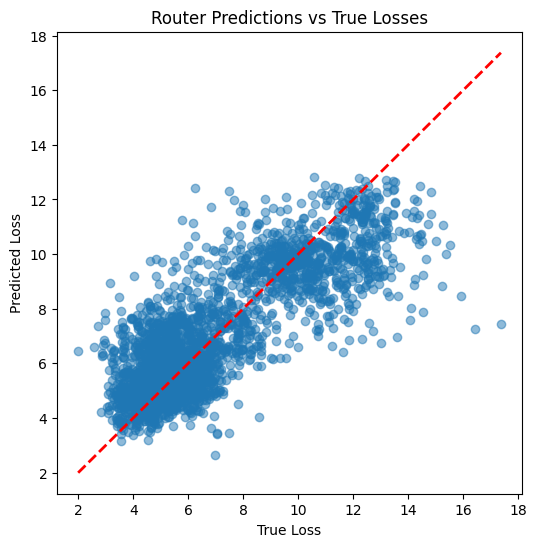

In [ ]:
import torch
import numpy as np

# ===============================
# LOAD BEST MODEL
# ===============================
ckpt = torch.load(output_model_path, weights_only=False)  # fix for PyTorch ≥2.6
router.load_state_dict(ckpt["model"])
router.eval()

# ===============================
# EVALUATION ON TEST SET
# ===============================
all_preds = []
all_true = []

with torch.no_grad():
    for embs, targets in test_loader:
        # Move to device and ensure float32
        embs = embs.to(device).float()
        targets = targets.float()

        # Model predictions
        preds = router(embs).cpu()
        preds = destandardize(preds)  # Convert back from standardized scale

        # Collect results
        all_preds.append(preds.numpy())
        all_true.append(targets.numpy())

# Combine all batches
all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)

# ===============================
# COMPUTE METRICS
# ===============================
mse = np.mean((all_preds - all_true) ** 2)
mae = np.mean(np.abs(all_preds - all_true))

print("Test MSE:", mse)
print("Test MAE:", mae)

# ===============================
# OPTIONAL: scatter plot of predictions vs true losses
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(all_true.flatten(), all_preds.flatten(), alpha=0.5)
plt.plot([all_true.min(), all_true.max()],
         [all_true.min(), all_true.max()],
         'r--', lw=2)
plt.xlabel("True Loss")
plt.ylabel("Predicted Loss")
plt.title("Router Predictions vs True Losses")
plt.show()


In [ ]:
def predict_losses(prompt):
    enc = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        # Get embedding from GPT-Neo
        emb = embedding_model.transformer.wte(enc["input_ids"]).mean(dim=1)
        # Router prediction (keep as tensor)
        pred = router(emb.float()).squeeze(0)
        # Destandardize while still a tensor
        pred = destandardize(pred)
    return pred.cpu().numpy()  # convert to NumPy only at the end

print(predict_losses("My name is Eric"))


[3.2637105 2.760454  2.123295 ]
